## Vegan Restaurant Analysis in Kiel: Finding the Optimal Cluster with Minimal Competition 🌱🗺️

# Task 1 - Story

<div class="alert alert-block alert-info">
In this Notebook, I will investigate clusters of vegan restaurants around Kiel, and help new companies find the optimal cluster with minimal competition.
</div>

# Task 2 - The Data

In [537]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [538]:
# importing data from csv file
# the data was querryed from an OpenStreetMap API in the gettingData.ipynb
data = pd.read_csv("data/restaurants_kiel.csv")

data.set_index("id", inplace=True)

The OpenStreetMap API returns an table of different restaurants and 122 attributes that are related to the restaurants.
To do this we need lattitute and longitude wich is represented in this dataset.

In [539]:
data.head(3)

,Unnamed: 0,type,lat,lon,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,amenity,...,changing_table:fee,drink:soy_milk,payment:electronic_purses,drink:coffee,bar,internet_access:ssid,currency:BCH,image,operator:type,note:de
id,,,,,,,,,,,,,,,,,,,,,
125623466,0,node,54.338116,10.128011,Kiel,DE,82,24118.0,Hansastraße,restaurant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125625723,1,node,54.337606,10.124073,Kiel,NaN,389,24118.0,Westring,cafe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125626070,2,node,54.339351,10.123098,Kiel,NaN,2,24118.0,Rudolf-Höber-Straße,cafe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Task 3 - IDA

## Geografical analysis

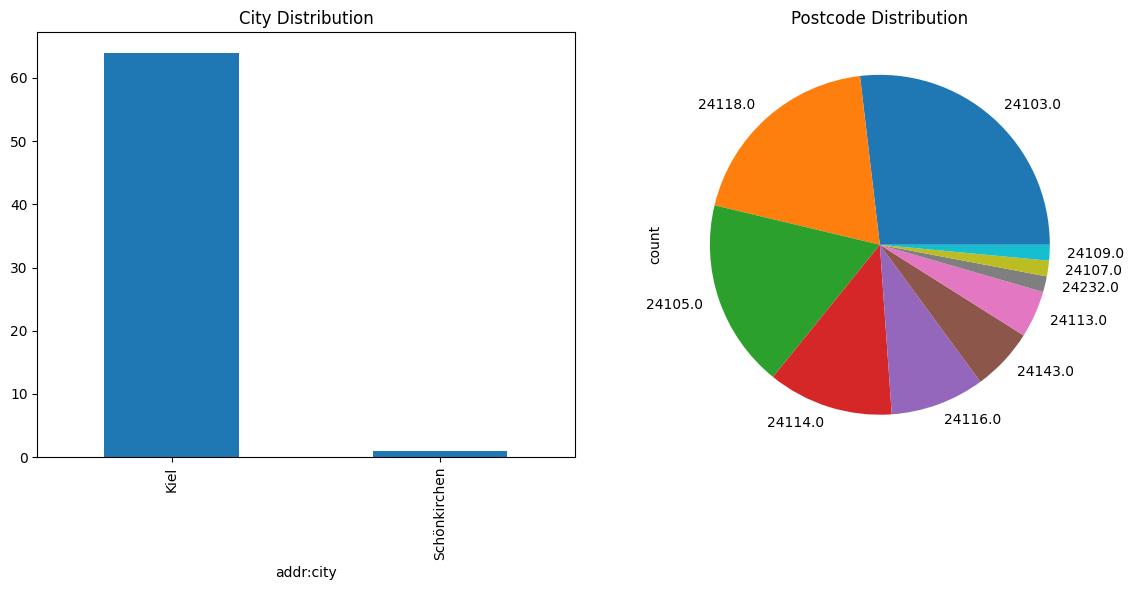

In [540]:
# Print the add:city distribution in a bar chart
plt.figure(figsize=(12, 6))  # Set the figure size as needed
plt.subplot(1, 2, 1)
plt.title('City Distribution')
data['addr:city'].value_counts().plot(kind='bar', ax=plt.gca())

# Print the add:postcode distribution in a pie chart
plt.subplot(1, 2, 2)
plt.title('Postcode Distribution')
data['addr:postcode'].value_counts().plot(kind='pie', ax=plt.gca())

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

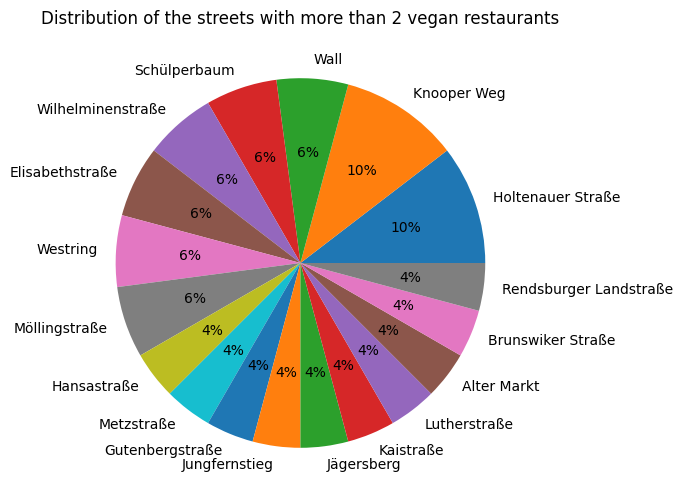

In [541]:
# Only return the values that are represented 2 or more times
data_filtered = data["addr:street"].value_counts()[data["addr:street"].value_counts() >= 2]

# Plot the pie chart with labels
plt.figure(figsize=(12, 6))  # Set the figure size as needed
data_filtered.plot.pie(autopct="%1.0f%%")
plt.title("Distribution of the streets with more than 2 vegan restaurants")
plt.ylabel("")
plt.show()

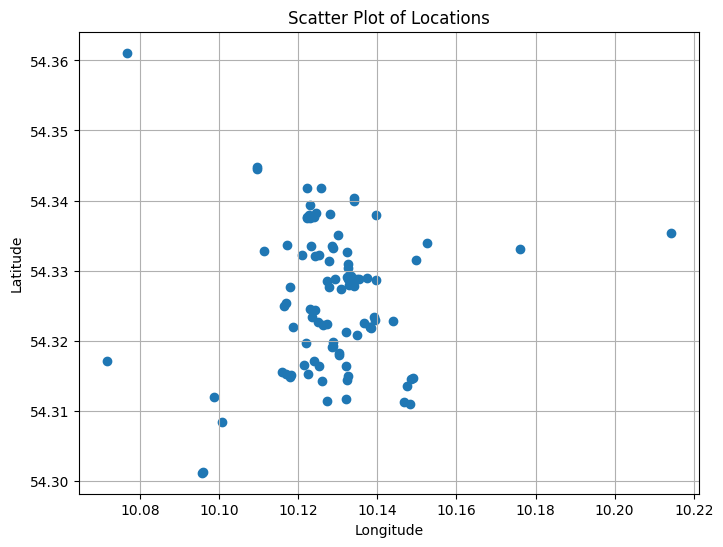

In [542]:
# Create a simple scatter plot
# TODO schön machen mit richtiger Karte :), vlt auch so daneben
plt.figure(figsize=(8, 6))
plt.scatter(data['lon'], data['lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Locations')
plt.grid(True)
plt.show()

In [543]:
# display statistical values about lat an lon
data[["lat", "lon"]].describe()

,lat,lon
count,96.000000,96.000000
mean,54.325829,10.128190
std,0.010236,0.016734
min,54.301161,10.071640
25%,54.317800,10.122422
50%,54.326405,10.128221
75%,54.332849,10.134093
max,54.361095,10.214153


## restaurant analysis

<Axes: title={'center': 'Cuisine Distribution'}, xlabel='cuisine'>

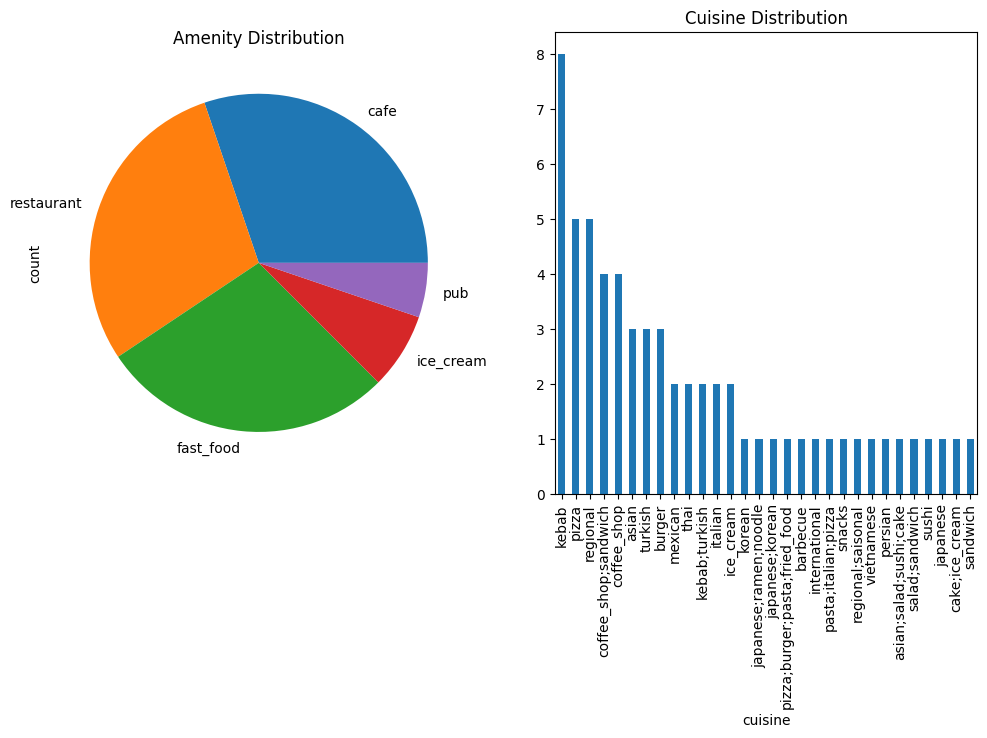

In [544]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Amenity Distribution")
plt.ylabel("")
data["amenity"].value_counts().plot(kind="pie", ax=plt.gca())

plt.subplot(1, 2, 2)
plt.title('Cuisine Distribution')
data["cuisine"].value_counts().plot(kind="bar", ax=plt.gca())

as we can see in the left graph above there are kinda equal ammount of fast_food, cafe and normal vegan restaurant distribution in kiel

<Axes: title={'center': 'Wheelchair accessibility in vegan restaurants'}, ylabel='count'>

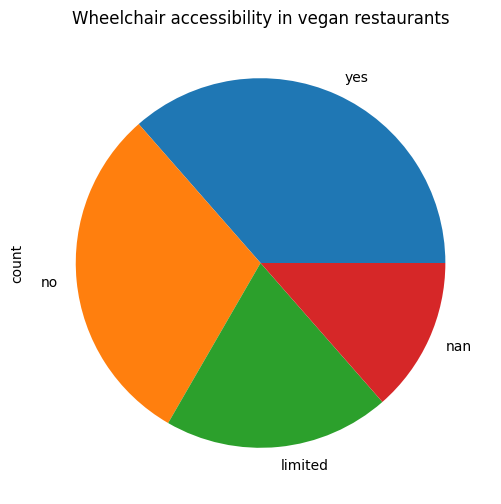

In [545]:
plt.figure(figsize=(12, 6))
plt.title('Wheelchair accessibility in vegan restaurants')
data["wheelchair"].value_counts(dropna=False).plot.pie()

this shows the distribution of wheelchare access, but the nan values have to be taken into consideration aswell

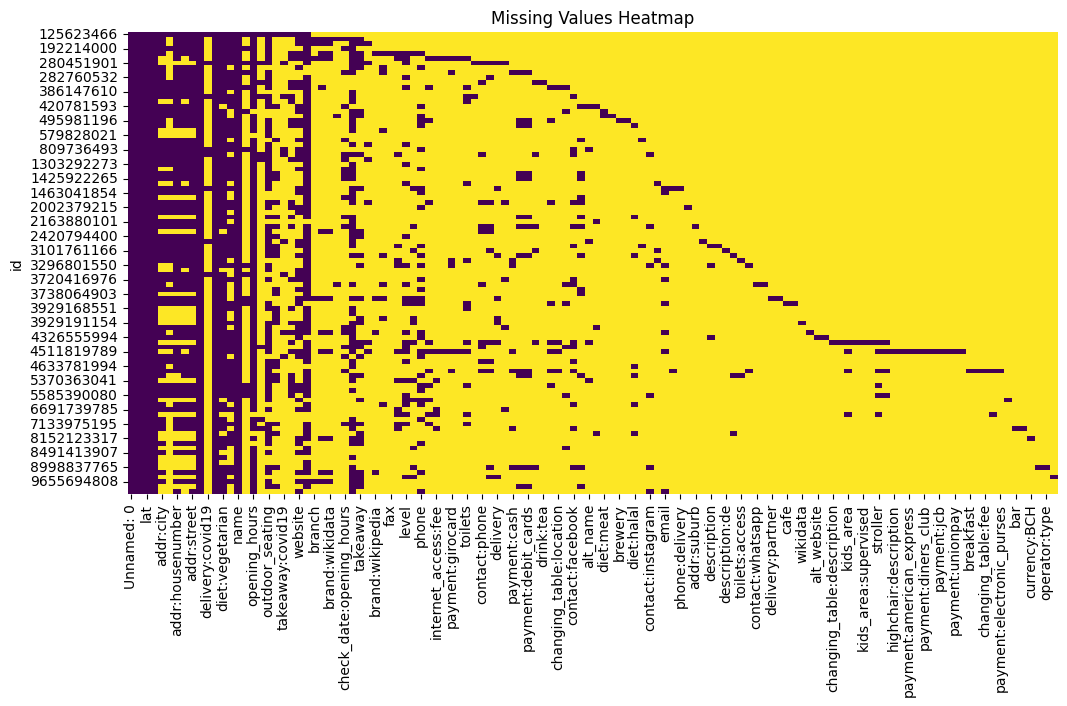

In [546]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(data.isna(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# inspired by https://stackoverflow.com/questions/47685905/matplotlib-heat-map-some-entries-missing-values

the heatmap above shows us what values are missing
on the y axis are different rows from the data
on the x axis are different attributes from the dataset

yellow entries represent a missing value of an attribute 
violette entries representing a present value of an attribute

on the left hand sinde we can see the attributes wich are commonly filled whil on the right hand sinde are mostly filled with nan values

In [547]:
# count na per attrobute of data

data.isna().sum().sort_values(ascending=True).head(10)

Unnamed: 0          0
type                0
lat                 0
name                0
amenity             0
diet:vegan          0
lon                 0
opening_hours       5
diet:vegetarian     8
wheelchair         13
dtype: int64

since open street map is a tool to display information on a UTM Map there are lat and lon values for every restaurant entry

looking at the lattitude and longitude we can see that there is a higher standard deriviation in lon so they are mor unequal on the y-axis on the map

# Task 4 - EDA and Preprocessing

In [548]:
# Since Unnamed: 0 is a index column, we will drop it
data.drop(columns=["Unnamed: 0"], inplace=True)

In [549]:
# since all attributes are from vegan restaurants and are nodes in OSM, we can drop the following columns
data.drop(columns=["type", "diet:vegan", "diet:vegetarian"], inplace=True)

In [550]:
# transforming wheelchair to categorical data
data["wheelchair"] = data["wheelchair"].astype("category")
data["amenity"] = data["amenity"].astype("category")

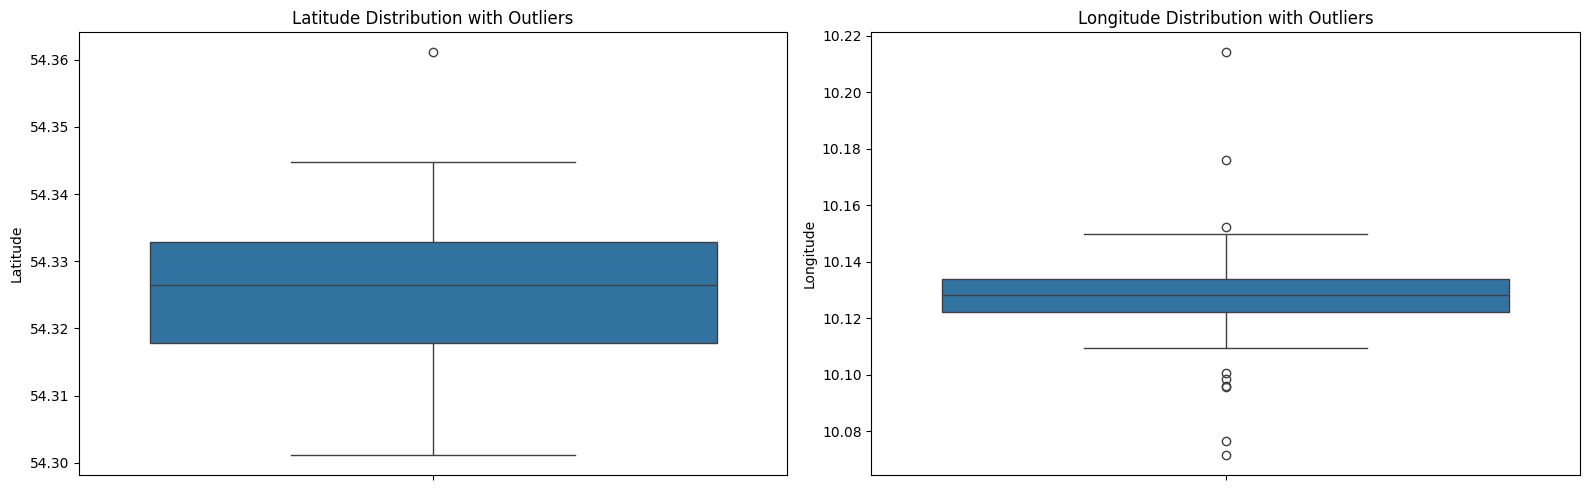

In [551]:
plt.figure(figsize=(16, 5))

# Plotting latitude box plot
plt.subplot(1, 2, 1)
plt.title("Latitude Distribution with Outliers")
sns.boxplot(y=data["lat"])
plt.ylabel("Latitude")

# Plotting longitude box plot
plt.subplot(1, 2, 2)
plt.title("Longitude Distribution with Outliers")
sns.boxplot(y=data["lon"])
plt.ylabel("Longitude")

plt.tight_layout()
plt.show()


In [552]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing outliers for 'lat' and 'lon' columns
# TODO: der überschreibt das einfach was vorher in lat gemcaht wurde lol
data = remove_outliers_iqr(data, 'lat')
data = remove_outliers_iqr(data, 'lon')

# Show the shape of the data before and after removing outliers
print("Shape of data after removing outliers:", data.shape)

Shape of data after removing outliers: (87, 118)


### Interquartile Range (IQR) 📊

The **Interquartile Range (IQR)** is a statistical measure used to assess the spread or dispersion within a dataset. It's particularly valuable for identifying potential outliers in the distribution of data.

#### Calculation 🧮:
- **Quartiles:**
  - **Q1 (First Quartile):** The value below which 25% of the data falls.
  - **Q2 (Second Quartile/Median):** The midpoint of the dataset, separating the higher and lower halves.
  - **Q3 (Third Quartile):** The value below which 75% of the data lies.
- **IQR Calculation:**
  - IQR is calculated as the difference between the third quartile (Q3) and the first quartile (Q1): 
    - **IQR = Q3 - Q1**

#### Use 🎯:
- **Outlier Detection:**
  - IQR is commonly used to identify potential outliers.
  - Outliers are often defined as data points falling below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

#### Importance 🌟:
- Provides a robust measure of data spread, less sensitive to extreme values compared to some other measures (e.g., range).


# Task 5 - Dimensionality Reduction 🛠️

We start by encoding non-numeric values within our dataset into numeric labels. This transformation enables us to employ Principal Component Analysis (PCA), a technique that requires numerical input.

The LabelEncoder is instrumental in this process, converting non-numeric categories into values within the range of 0 to 1. This numerical representation facilitates the application of various machine learning algorithms.

In [553]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
label_encoder = LabelEncoder()

# Copy the dataframe to avoid modifying the original data
restaurants_encoded_df = data.copy()

# Apply label encoding to non-numeric columns
non_numeric_columns = restaurants_encoded_df.select_dtypes(exclude=['number']).columns
restaurants_encoded_df[non_numeric_columns] = restaurants_encoded_df[non_numeric_columns].apply(lambda col: label_encoder.fit_transform(col.astype(str)), axis=0)

# Display the first few rows of the encoded dataframe
restaurants_encoded_df.head()

,lat,lon,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,amenity,delivery:covid19,indoor_seating,...,changing_table:fee,drink:soy_milk,payment:electronic_purses,drink:coffee,bar,internet_access:ssid,currency:BCH,image,operator:type,note:de
id,,,,,,,,,,,,,,,,,,,,,
125623466,54.338116,10.128011,0,0,50,24118.0,10,4,1,2,...,0,0,0,0,0,1,0,1,1,1
125625723,54.337606,10.124073,0,1,30,24118.0,35,0,0,2,...,0,0,0,0,0,1,0,1,1,1
125626070,54.339351,10.123098,0,1,14,24118.0,31,0,0,1,...,0,0,0,0,0,1,0,1,1,1
192214000,54.341774,10.125772,0,0,35,24118.0,35,4,0,2,...,0,0,0,0,0,1,0,1,1,1
268223175,54.322519,10.136583,0,1,25,24103.0,12,1,0,2,...,0,0,0,0,0,1,0,1,1,1


In [554]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [555]:
# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(restaurants_encoded_df)


/home/mbrucker/sem1/sem1_math_and_stats/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/mbrucker/sem1/sem1_math_and_stats/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/mbrucker/sem1/sem1_math_and_stats/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [556]:
# print the % of missing values in relation to the total number of values
np.isnan(X_std).sum()/np.isreal(X_std).sum()

0.01948178453146308

In [557]:
# Impute missing values with median
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_std = imp.fit_transform(X_std)

/home/mbrucker/sem1/sem1_math_and_stats/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [87]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


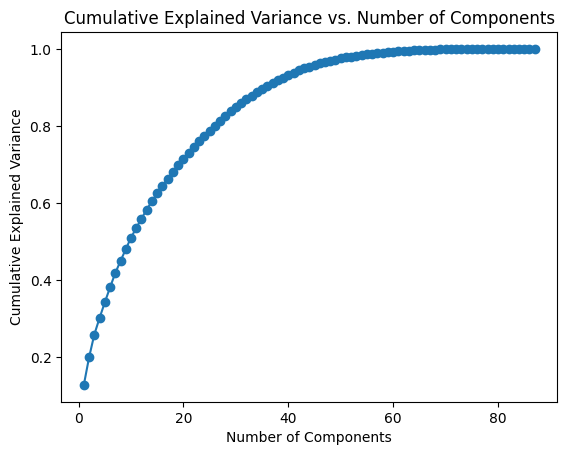

The optimal number of components is: 33


In [558]:
pca = PCA()
pca.fit(X_std)
explained_var = pca.explained_variance_ratio_

# Assuming you have already obtained the explained variance
cumulative_explained_var = np.cumsum(explained_var)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_var) + 1), cumulative_explained_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.show()

# Find the index corresponding to the elbow point
elbow_index = np.argmax(np.diff(cumulative_explained_var) < 0.01) + 1
optimal_components = elbow_index + 1  # Add 1 because indexing starts from 1

print(f"The optimal number of components is: {optimal_components}")


As for the comment about taking 33 components despite the lack of relevance, it seems to be a note regarding experimentation or exploration with PCA parameters despite their potential lack of meaningfulness in the context of geographic data. It's always important to consider the context and characteristics of your data when choosing techniques like PCA 🚀.

# Task 6 - Clustering

In this chapter, we will explore two clustering methods: the kMeans clustering method and the more advanced OPTICS clustering method. 🤖🔍

## K-Means Clustering

K-Means clustering is a widely used method for grouping data points. In our case, it is applied to cluster restaurants in Kiel based on their latitude and longitude. Here's why K-Means is suitable for this use case:

- **Simplicity and Efficiency:** K-Means is computationally efficient and easy to implement, making it suitable for large datasets. 💻⚡

- **Well-Separated Clusters:** If the underlying structure of the data consists of well-separated, spherical clusters, K-Means tends to perform well. 🌐🔄

## OPTICS Clustering

OPTICS (Ordering Points To Identify the Clustering Structure) is a more advanced clustering method that takes into account the density structure of the data. Here's why OPTICS is suitable for our use case:

- **Density-Based Clustering:** OPTICS is particularly effective in identifying clusters of varying shapes and sizes, making it robust in the presence of noise and outliers. 📊👥

- **Hierarchical Structure:** OPTICS reveals the hierarchical structure of the data, providing insights into the density connectivity of points. 🌳🔗

## Differences and Synergy

While both K-Means and OPTICS are used for clustering, they have key differences:

- **Cluster Shape Sensitivity:** K-Means assumes spherical clusters, whereas OPTICS is more flexible and can handle clusters of varying shapes. 🔄🔵

- **Hierarchical vs. Partitional:** K-Means assigns each point to a single cluster (partitional), while OPTICS unveils a hierarchical clustering structure. 🏰🔍

- **Handling Noise:** OPTICS is robust to noise and outliers due to its density-based approach, while K-Means can be sensitive to outliers. 🚫📈

Understanding the strengths and weaknesses of each method allows us to leverage their complementary aspects. In practice, combining K-Means and OPTICS can provide a more comprehensive view of the data's clustering structure, addressing different patterns and nuances. 🤝🌐


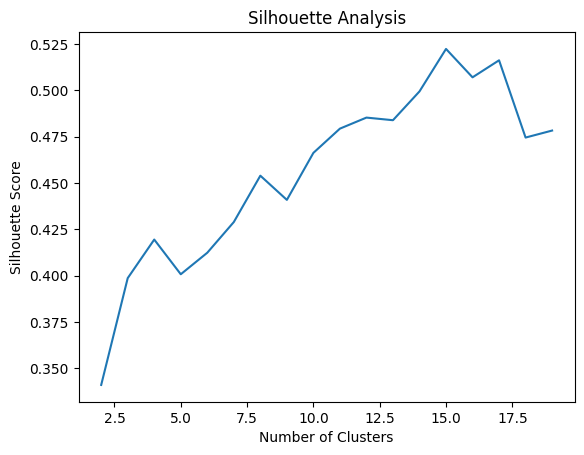

The best number of clusters based on silhouette score is: 15


In [559]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select the columns of interest
selected_columns = data[["lat", "lon"]]

# Standardize the data
scaler = StandardScaler()
selected_columns_scaled = scaler.fit_transform(selected_columns)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
selected_columns_pca = pca.fit_transform(selected_columns_scaled)

# Perform silhouette analysis to find the optimal number of clusters
silhouette_scores = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(selected_columns_pca)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(selected_columns_pca, labels))

# Plot silhouette scores
plt.plot(range(2, 20), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Find the best number of clusters with the highest silhouette score
best_cluster = silhouette_scores.index(max(silhouette_scores)) + 2  # Adding 2 to start from index 2
print("The best number of clusters based on silhouette score is:", best_cluster)

Based on our rule of Thumb a Silhouette score from 0 till 0.5 is not that good since the clusters do not seperate that good.
Anyway for demonstration purposes we are going to use them in this notebook.

In [560]:
# Apply K-means clustering to the dataset
from sklearn.cluster import KMeans

# Select only the numeric columns (lat and lon)
restaurants_kiel_numeric = data[['lat', 'lon']].dropna()

# Standardize the numeric columns
restaurants_kiel_scaled = scaler.fit_transform(restaurants_kiel_numeric)

# Apply K-means clustering
kmeans = KMeans(n_clusters=15, random_state=0).fit(restaurants_kiel_scaled)

# Add the cluster labels to the dataframe
data['clusterKMeans'] = kmeans.labels_

/home/mbrucker/sem1/sem1_math_and_stats/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [561]:
from sklearn.cluster import OPTICS

# Select only the numeric columns (lat and lon)
restaurants_kiel_numeric = data[['lat', 'lon']]

# Standardize the numeric columns
restaurants_kiel_scaled = scaler.fit_transform(restaurants_kiel_numeric)

# Apply OPTICS clustering
optics = OPTICS(min_samples=15, xi=0.05, min_cluster_size=0.05)
optics.fit(restaurants_kiel_scaled)

# Add the cluster labels to the dataframe
data['clusterOptics'] = optics.labels_

# Task 7 - Cluster Interpretation

In [562]:
import folium
# Create a map centered around Kiel
m = folium.Map(location=[54.3233, 10.1228], zoom_start=12)

# Define a color map for the clusters
num_clusters = len(set(data['clusterKMeans']))
cluster_colors = sns.color_palette("husl", num_clusters).as_hex()

# Add markers for each restaurant with cluster color
for index, row in data.iterrows():
    folium.CircleMarker([row['lat'], row['lon']], radius=5, color=cluster_colors[row['clusterKMeans']], fill=True, fill_color=cluster_colors[row['clusterKMeans']]).add_to(m)

# Display the map
m

In [563]:
# Create a map centered around Kiel
m = folium.Map(location=[54.3233, 10.1228], zoom_start=12)

# Define a color map for the clusters using seaborn color_palette
num_clusters = len(set(data['clusterOptics']))
cluster_colors = sns.color_palette("husl", num_clusters).as_hex()

# Add markers for each restaurant with cluster color
for index, row in data.iterrows():
    folium.CircleMarker([row['lat'], row['lon']], radius=5, color=cluster_colors[row['clusterOptics']], fill=True, fill_color=cluster_colors[row['clusterOptics']]).add_to(m)

# Display the map
m

### differences between kmeans and OPTICS

first of all when watching the graph you can see on first clance that the diferent clustering mehtodes choosed another ammount of clusters
There are 5 different k means cluster and 9 different optics cluster.

as shown in the maps above, you can really see the differences between kmeans and OPTICS by how they create clusters.
For example with optics all outside clusters are grouped in once single cluster while with k means 



OPTICS 
https://dl.acm.org/doi/pdf/10.1145/304181.304187

In [564]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Define the features for fitting the clustering algorithm
features = data[['lat', 'lon']]  # Assuming 'lat' and 'lon' are columns in your DataFrame

# Extract cluster labels
labels = data['clusterKMeans']

# Calculate evaluation metrics
silhouette_avg = silhouette_score(features, labels)
calinski_harabasz = calinski_harabasz_score(features, labels)
davies_bouldin = davies_bouldin_score(features, labels)

print(f"Silhouette Score KMeans: {silhouette_avg}")
print(f"Calinski-Harabasz Index KMeans: {calinski_harabasz}")
print(f"Davies-Bouldin Index KMeans: {davies_bouldin}")


Silhouette Score KMeans: 0.5224519089531832
Calinski-Harabasz Index KMeans: 124.26603255955773
Davies-Bouldin Index KMeans: 0.5190836233729987


In [565]:
features = data[['lat', 'lon']]

# Extract cluster labels
labels = data['clusterOptics']

# Calculate evaluation metrics
silhouette_avg = silhouette_score(features, labels)
calinski_harabasz = calinski_harabasz_score(features, labels)
davies_bouldin = davies_bouldin_score(features, labels)

print(f"Silhouette Score OPTICS: {silhouette_avg}")
print(f"Calinski-Harabasz Index OPTICS: {calinski_harabasz}")
print(f"Davies-Bouldin Index OPTICS: {davies_bouldin}")


Silhouette Score OPTICS: 0.020557891438042784
Calinski-Harabasz Index OPTICS: 3.4180120203418802
Davies-Bouldin Index OPTICS: 2.8469651410805836


- **Silhouette Score:**
    - *KMeans Clusters:* 0.5224 😬 (Moderate)
    - *OPTICS Clusters:* 0.0205 🥺 (Low)

- **Calinski-Harabasz Index:**
    - *KMeans:* 124.266 😐 (Moderately Good)
    - *OPTICS:* 3.4180 😬🌟 (Low)

- **Davies-Bouldin Index:**
    - *KMeans:* 0.519 😊🌟 (Better)
    - *OPTICS:* 2.8469 😬 (Moderate)

In essence:

KMeans exhibits moderate scores across all metrics🏆. 
Meanwhile, OPTICS, while showing potential in the Calinski-Harabasz Index, demonstrates weaker performance overall, especially with a higher Davies-Bouldin Index, indicating less desirable clustering quality 🌟.

# Task 8 - Conclusion and Future Work

On basis of the data i would reccomend the new enterprise to be open


Improvements that could be made:
Sure thing, the better the data basis the more analysis is possible to be done with the data. As presentet there are many attributes that are filled wit NAN values, with a broader participation in the open street map community further analysis would be possible to be done.

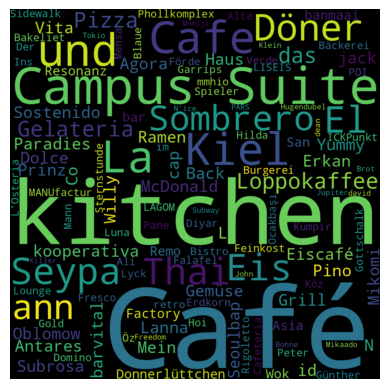

In [566]:
# Libraries
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a list of word
text = data["name"].to_string()

# Create the wordcloud object
wordcloud = WordCloud(width=1080, height=1080, margin=0).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()